### Task 1

Let's start with obtaining vocabulary from 2 texts of nltk.gutenberg

In [19]:
from nltk.book import *
def get_vocabulary(texts):
    voc = []
    for text in texts:
        voc.extend(gutenberg.words(text))
    voc = sorted(list(set(voc)))
    return voc
vocabulary = get_vocabulary(['melville-moby_dick.txt', 'Austen-Emma.txt'])
vocabulary = vocabulary[vocabulary.index("A"):]
vocabulary

['A',
 'ABOUT',
 'ACCOUNT',
 'ADDITIONAL',
 'ADVANCING',
 'ADVENTURES',
 'AFFGHANISTAN',
 'AFRICA',
 'AFTER',
 'AGAINST',
 'AHAB',
 'ALFRED',
 'ALGERINE',
 'ALIVE',
 'ALL',
 'ALONE',
 'AM',
 'AMERICA',
 'AMONG',
 'ANCHORS',
 'AND',
 'ANGLO',
 'ANIMAL',
 'ANNALS',
 'ANNUS',
 'ANOTHER',
 'ANY',
 'APOLOGY',
 'APPLICATION',
 'APPROACHING',
 'ARCTIC',
 'ARE',
 'AROUND',
 'AS',
 'ASCENDING',
 'ASIA',
 'ASIDE',
 'ASPECT',
 'AT',
 'ATTACK',
 'ATTACKED',
 'ATTITUDES',
 'AUGUST',
 'AUTHOR',
 'AZORE',
 'Abashed',
 'Abbey',
 'Abbots',
 'Abdy',
 'Abednego',
 'Abel',
 'Abjectus',
 'Aboard',
 'Abominable',
 'About',
 'Above',
 'Abraham',
 'Absence',
 'Absolute',
 'Absolutely',
 'Absurd',
 'Academy',
 'Accessory',
 'According',
 'Accordingly',
 'Accursed',
 'Achilles',
 'Acquit',
 'Actium',
 'Actually',
 'Acushnet',
 'Adam',
 'Adelaide',
 'Adieu',
 'Adios',
 'Admiral',
 'Admirals',
 'Adopt',
 'Advance',
 'Advancement',
 'Adventures',
 'Adverse',
 'Advocate',
 'Affected',
 'Affidavit',
 'Affrighted',
 

Now lets create a function to count the words occurances and co_occurances in paragraphs.

In [120]:
from nltk.tokenize import word_tokenize
import numpy as np
def get_paragraphs(corpus):
    paragraphs = []
    for text in corpus:
        paragraphs += [p.strip().lower() for p in gutenberg.raw(text).split('\r\n\r\n') if p.strip()]
    return paragraphs


def co_parag(word, context, corpus):
    paragraphs = get_paragraphs(corpus)
    w_occurance, c_occurance, co_occurance = 0, 0, 0
    for paragraph in paragraphs:
        words = word_tokenize(paragraph)
        co_occurance += word.lower() in words and context.lower() in words
        w_occurance += word.lower() in words
        c_occurance += context.lower() in words
    return np.array([w_occurance, c_occurance, co_occurance])


moby_dick = 'melville-moby_dick.txt'
emma = 'Austen-Emma.txt'
co_parag("the", "a", [moby_dick, emma])

array([2176, 1566, 1438])

Finally let's calculate PPMI

In [86]:
def ppmi(word, context, corpus):
    occurances = co_parag(word, context, corpus) / len(get_paragraphs(corpus))
    ppmi = np.log2(occurances[2] / (occurances[0]*occurances[1])) 
    ppmi = max([ppmi, 0])
    return ppmi
ppmi("the", "a", [moby_dick, emma])

0.23763292730738073

The value is > 0, so there is a dependence between the word and the context

In [62]:
ppmi("Moby", "dick", [moby_dick, emma])

5.298369185904781

On the other hand, this dependence is much stronger.

### Task 2

Let's create a function to calculate co_occurances in the sliding window.

In [183]:
def get_words(corpus):
    words = []
    for text in corpus:
        words += list(gutenberg.words(text))
    return words

def co_window(word, context, corpus):
    words = get_words(corpus)
    w_occurance, c_occurance, co_occurance = 0, 0, 0
    for idx, w in enumerate(list(words)):
        if w.lower() == context.lower():
            c_occurance += 1
        elif w.lower() == word.lower():
            w_occurance += 1
            co_occurance += context.lower() in list(map(lambda x: x.lower(), words[idx-5: idx+5]))
    return np.array([w_occurance, c_occurance, co_occurance])
co_window("moby", "dick", [moby_dick, emma])

array([84, 84, 83])

In [184]:
def ppmi2(word, context, corpus):
    occurances = co_window(word, context, corpus) / len(get_words(corpus))
    ppmi = np.log2((occurances[2]) / (occurances[0]*occurances[1])) 
    ppmi = max([ppmi, 0])
    return ppmi 
ppmi2("moby", "dick", [moby_dick, emma])

12.380339348136902

Because the number of words is huge the probability of occurances is low and the value of ppmi is higher. Now we will discuss the idea how to deal with it

### Task 3

To solve the proble we can use the `Add-one smoothing` method. The problem arises because we have very small occurance values for the infrequent words. So if we added some small positive constant to the numerator and denominator in PPMMI formula, the value for the infrequent words would normilize, as adding even a very small constant will decrease the value, while value for the frequent words will not change a lot with adding a tiny constant. Let's check it

In [178]:
def ppmi2_upd(word, context, corpus):
    occurances = co_window(word, context, corpus) / len(get_words(corpus))
    ppmi = np.log2((occurances[2] + 1e-5) / (occurances[0]*occurances[1] + 1e-5)) 
    ppmi = max([ppmi, 0])
    return ppmi 


In [179]:
print("-" * 20 + "For frequent words" + "-"*20)
print(f'Before Add-one smoothing PPMI for "the" and "a": {ppmi2("the", "a", [moby_dick, emma])}')
print(f'After Add-one smoothing PPMI for "the" and "a": {ppmi2_upd("the", "a", [moby_dick, emma])}')
print("-" * 20 + "For infrequent words" + "-"*20)
print(f'Before Add-one smoothing PPMI for "Moby" and "Dick": {ppmi2("Moby", "Dick", [moby_dick, emma])}')
print(f'After Add-one smoothing PPMI for "Moby" and "Dick": {ppmi2_upd("Moby", "Dick", [moby_dick, emma])}')

--------------------For frequent words--------------------
Before Add-one smoothing PPMI for "the" and "a": 2.226220092372014
After Add-one smoothing PPMI for "the" and "a": 2.2112484636462186
--------------------For infrequent words--------------------
Before Add-one smoothing PPMI for "Moby" and "Dick": 12.380339348136902
After Add-one smoothing PPMI for "Moby" and "Dick": 4.266505168587376


We can see that it worked pretty good. Ofcourse there are many other ways to do that.

### Task 4

Lets choose word `big` and 10 synonyms to the word and calculate ppmi as a heattable. 

In [138]:
syns = ["large", "considerable", "substantial", "great","huge", "bulky", "grand", "colossal", "high", "noble"]
word = "big"
ppmis = [ppmi(word, syn, [moby_dick, emma]) for syn in syns]
ppmis

C:\Users\User\AppData\Local\Temp\ipykernel_7624\563446459.py:3: RuntimeWarning: divide by zero encountered in log2
  ppmi = np.log2(occurances[2] / (occurances[0]*occurances[1]))


[1.5382232216394212, 0, 0, 0.7589919004962051, 0, 0, 0, 0, 0, 0]

In [139]:
import pandas as pd
import seaborn as sns
ppmis = pd.DataFrame({"synonyms": syns, "big": ppmis}).set_index("synonyms")
ppmis

,big
synonyms,
large,1.538223
considerable,0.000000
substantial,0.000000
great,0.758992
huge,0.000000
bulky,0.000000
grand,0.000000
colossal,0.000000
high,0.000000


<AxesSubplot:ylabel='synonyms'>

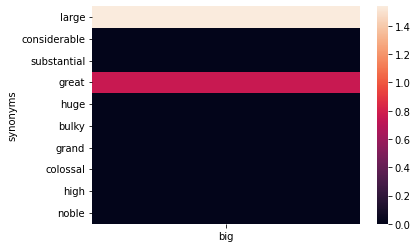

In [140]:
sns.heatmap(ppmis)

We can see that `great` and `large` occure the most with `big`.